In [1]:
!pip install arrow
!pip install category-encoders
!pip install icecream
# !pip install matplotlib
# !pip install numpy
# !pip install pandas
!pip install tqdm

In [2]:
import arrow
import category_encoders as ce
from collections import Counter
from icecream import ic
from math import ceil
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm import tqdm

# Load Data

In [3]:
data=pd.read_csv("/kaggle/input/credit-card-fraud-v3/smallboi_v2.csv")

In [4]:
# files = os.listdir("D:\Downloads\Hackathon\Small_Data")
# files.remove("customers.csv")
# print(files, len(files))

# wd = "D:\Downloads\Hackathon\Small_Data"
# data = pd.concat([ pd.read_csv(wd+"\\"+file, sep="|") for file in files ], ignore_index=True)
# data.to_csv("data.csv")

 #df = data.copy()

# df['trans_age'] = df.trans_date.apply(lambda row: arrow.get(row, "YYYY-MM-DD").year) - df.dob.apply(lambda row: arrow.get(row, "YYYY-MM-DD").year)
# df_trans_age = df.drop(df[(df.trans_age < 18) & (df.is_fraud == 0)].index)
# df_trans_age.to_csv("smallboi.csv")

In [5]:
data_clean=data.copy()

In [6]:
# data = pd.read_csv("bigboi.csv")
#data_clean = pd.read_csv("smallboi.csv", index_col=0, header=0)
# data_clean.reset_index(inplace=True)
# df = data_clean.copy()

# EDA

In [7]:
# data_clean.drop('index', axis=1, inplace=True)
# data_clean['trans_year'] = data_clean['trans_date'].apply(lambda row: arrow.get(row, "YYYY-MM-DD").year)
# data_clean.to_csv("smallboi.csv")

In [8]:
col_names = data_clean.columns
print(col_names)

Index(['Unnamed: 0', 'ssn', 'cc_num', 'first', 'last', 'gender', 'street',
       'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob',
       'acct_num', 'profile', 'trans_num', 'trans_date', 'trans_time',
       'unix_time', 'category', 'amt', 'is_fraud', 'merchant', 'merch_lat',
       'merch_long', 'trans_age', 'trans_year'],
      dtype='object')


In [9]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12925615 entries, 0 to 12925614
Data columns (total 29 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   ssn         object 
 2   cc_num      int64  
 3   first       object 
 4   last        object 
 5   gender      object 
 6   street      object 
 7   city        object 
 8   state       object 
 9   zip         int64  
 10  lat         float64
 11  long        float64
 12  city_pop    int64  
 13  job         object 
 14  dob         object 
 15  acct_num    int64  
 16  profile     object 
 17  trans_num   object 
 18  trans_date  object 
 19  trans_time  object 
 20  unix_time   int64  
 21  category    object 
 22  amt         float64
 23  is_fraud    int64  
 24  merchant    object 
 25  merch_lat   float64
 26  merch_long  float64
 27  trans_age   int64  
 28  trans_year  int64  
dtypes: float64(5), int64(9), object(15)
memory usage: 2.8+ GB


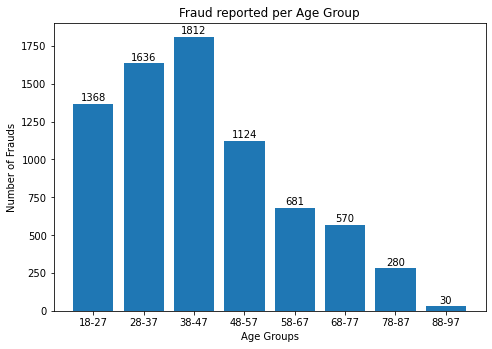

In [10]:
start = 18
window = 9
inc = 10
max_age = data_clean.trans_age.unique().max()
bins = 0
fraud_to_age = {}
while (start <= max_age):
    fraud_to_age[start] = data_clean[(start <= data_clean['trans_age']) & (data_clean['trans_age'] <= start+window)].is_fraud.sum()
    bins += 1
    start += inc
x = range(len(fraud_to_age))
y = fraud_to_age.values()
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
g = ax.bar(x, y)
ax.set_xticks(range(len(fraud_to_age)), [ str(str(k)+"-"+str(k+window)) for k in fraud_to_age.keys() ])
ax.bar_label(g, padding=1)
ax.set_xlabel("Age Groups")
ax.set_ylabel("Number of Frauds")
ax.set_title("Fraud reported per Age Group")
plt.show()

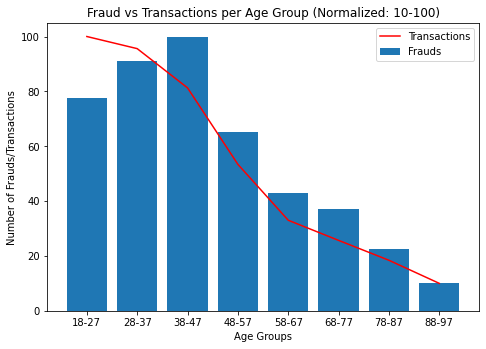

In [11]:
start = 18
window = 9
inc = 10
max_age = data_clean.trans_age.unique().max()
bins = 0
fraud_to_age = {}
trans_to_age = {}
while (start <= max_age):
    fraud_to_age[start] = data_clean[(start <= data_clean['trans_age']) & (data_clean['trans_age'] <= start+window)].is_fraud.sum()
    trans_to_age[start] = len(data_clean[(start <= data_clean['trans_age']) & (data_clean['trans_age'] <= start+window)])
    bins += 1
    start += inc
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
fraud_trans_age_df = pd.DataFrame({'frauds':fraud_to_age.values(), 'trans':trans_to_age.values()}, index=list(fraud_to_age.keys()))
fraud_trans_age_df_norm = (fraud_trans_age_df - fraud_trans_age_df.min()) / (fraud_trans_age_df.max() - fraud_trans_age_df.min())
y_norm = fraud_trans_age_df_norm.frauds.values.tolist()
y_trans_norm = fraud_trans_age_df_norm.trans.values.tolist()
lower, upper = 10, 100
y_norm = [ lower + (upper - lower) * val for val in y_norm ]
y_trans_norm = [ lower + (upper - lower) * val for val in y_trans_norm ]
g = ax.bar(x, y_norm)
g_trans = ax.plot(x, y_trans_norm, c='red')
ax.set_xticks(range(len(fraud_to_age)), [ str(str(k)+"-"+str(k+window)) for k in fraud_to_age.keys() ])
ax.set_xlabel("Age Groups")
ax.set_ylabel("Number of Frauds/Transactions")
ax.set_title("Fraud vs Transactions per Age Group (Normalized: 10-100)")
ax.legend(["Transactions", "Frauds"])
plt.show()

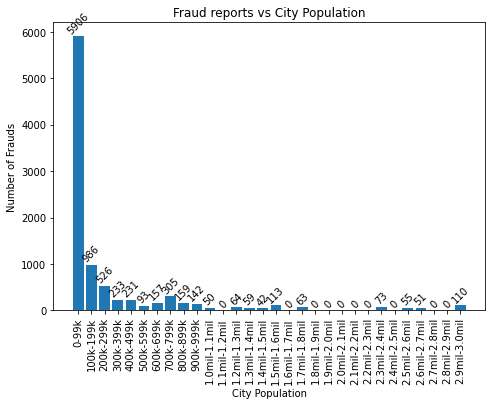

In [12]:
start = 0
window = 99999
inc = 100000
max_pop = data_clean.city_pop.unique().max()
bins = 0
fraud_to_pop = {}
while (start <= max_pop):
    fraud_to_pop[start] = data_clean[(start <= data_clean['city_pop']) & (data_clean['city_pop'] <= start+window)].is_fraud.sum()
    bins += 1
    start += inc
x = range(len(fraud_to_pop))
y = fraud_to_pop.values()
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
g = ax.bar(x, y)
initial_tick_label = f"0-{str((list(fraud_to_pop.keys())[0]+window)//1000)}k"
remaining_ticks = {}
for i, k in enumerate(list(fraud_to_pop.keys())[1:], start=1):
    if ((k+window)//1000) < 1000:
        remaining_ticks[i] = f"{str(k//1000)}k-{str((k+window)//1000)}k"
    else:
        remaining_ticks[i] = f"{str(k/1000000)}mil-{str(round((k+window)/1000000, 2))}mil"
ax.set_xticks(range(len(fraud_to_pop)))
labels = [initial_tick_label]
labels.extend(list(remaining_ticks.values()))
ax.set_xticklabels(labels, rotation=90)
ax.bar_label(g, padding=1, rotation=45)
ax.set_xlabel("City Population")
ax.set_ylabel("Number of Frauds")
ax.set_title("Fraud reports vs City Population")
plt.show()

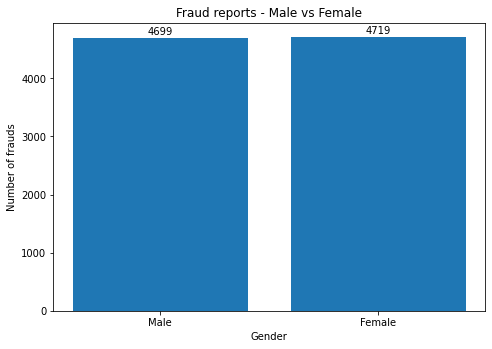

In [13]:
male_fraud = len(data_clean[(data_clean['is_fraud']==1) & (data_clean['gender']=="M")])
female_fraud = len(data_clean[(data_clean['is_fraud']==1) & (data_clean['gender']=="F")])
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
x = range(2)
y = [male_fraud, female_fraud]
g = ax.bar(x, y)
ax.set_xticks(x, ["Male", "Female"])
ax.bar_label(g, padding=1)
ax.set_xlabel("Gender")
ax.set_ylabel("Number of frauds")
ax.set_title("Fraud reports - Male vs Female")
plt.show()

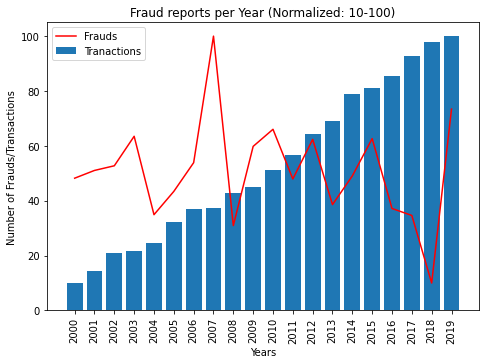

In [14]:
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
x = range(2000, 2020)
y = [ data_clean[data_clean['trans_year']==yr].is_fraud.sum() for yr in x ]
y_trans = [ len(data_clean[data_clean['trans_year']==yr]) for yr in x ]
fraud_year_df = pd.DataFrame({'frauds':y, 'trans':y_trans})
fraud_year_df_norm = (fraud_year_df - fraud_year_df.min()) / (fraud_year_df.max() - fraud_year_df.min())
y_norm = fraud_year_df_norm.frauds.values.tolist()
y_trans_norm = fraud_year_df_norm.trans.values.tolist()
lower, upper = 10, 100
y_norm = [ lower + (upper - lower) * val for val in y_norm ]
y_trans_norm = [ lower + (upper - lower) * val for val in y_trans_norm ]
g_trans = ax.bar(x, y_trans_norm)
g = ax.plot(x, y_norm, c="red")
ax.set_xticks(x)
ax.set_xticklabels(x, rotation=90)
ax.set_xlabel("Years")
ax.set_ylabel("Number of Frauds/Transactions")
ax.set_title("Fraud reports per Year (Normalized: 10-100)")
ax.legend(["Frauds", "Tranactions"])
plt.show()

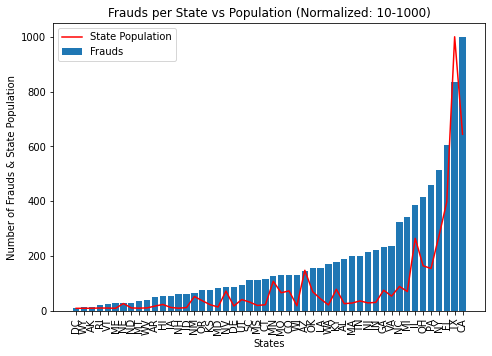

In [15]:
states = data_clean['state'].unique()
data_group_state = data_clean.groupby('state')
x = range(len(states))
y = { st:data_clean[data_clean['state'] == st].is_fraud.sum() for st in states }
y_sorted = sorted(y, key=y.get)
y_val_sorted = [ y[key] for key in y_sorted ]
y_pop = [ data_group_state.sum().loc[st].city_pop for st in y_sorted ]
fraud_pop_df = pd.DataFrame(data={'frauds':y_val_sorted, 'state_pop':y_pop}, index=y_sorted)
fraud_pop_df_norm = (fraud_pop_df - fraud_pop_df.min()) / (fraud_pop_df.max() - fraud_pop_df.min())
y_norm = fraud_pop_df_norm.frauds.values.tolist()
y_pop_norm = fraud_pop_df_norm.state_pop.values.tolist()
lower, upper = 10, 1000
y_norm = [ lower + (upper - lower) * val for val in y_norm ]
y_pop_norm = [ lower + (upper - lower) * val for val in y_pop_norm ]
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
g = ax.bar(x, y_norm)
g_pop = ax.plot(x, y_pop_norm, c='red')
ax.set_xticks(x, y_sorted, rotation=90)
ax.set_xlabel("States")
ax.set_ylabel("Number of Frauds & State Population")
ax.set_title("Frauds per State vs Population (Normalized: 10-1000)")
ax.legend(["State Population", "Frauds"])
plt.show()

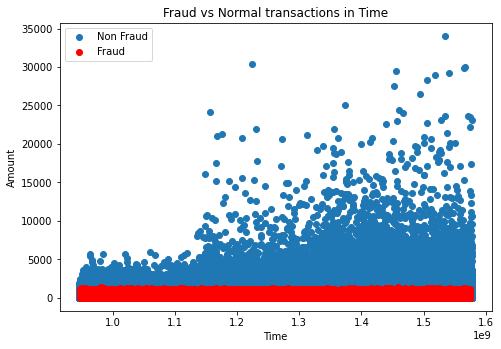

In [16]:
fraud_trans_time = data_clean[data_clean['is_fraud']==1].unix_time.values.tolist()
normal_trans_time = data_clean[data_clean['is_fraud']==0].unix_time.values.tolist()
fraud_trans_amt = data_clean[data_clean['is_fraud']==1].amt.values.tolist()
normal_trans_amt = data_clean[data_clean['is_fraud']==0].amt.values.tolist()
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
g = ax.scatter(normal_trans_time, normal_trans_amt)
g_fraud = ax.scatter(fraud_trans_time, fraud_trans_amt, c='red')
ax.set_xlabel("Time")
ax.set_ylabel("Amount")
ax.set_title("Fraud vs Normal transactions in Time")
ax.legend(["Non Fraud", "Fraud"], loc='upper left')
plt.show()

In [18]:
print(type(data_clean))

<class 'pandas.core.frame.DataFrame'>


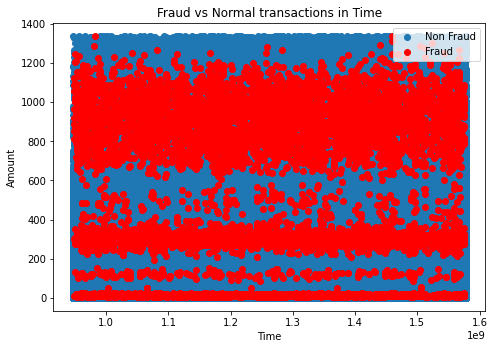

In [19]:
max_fraud_amt = max(fraud_trans_amt)
fraud_trans_time = data_clean[(data_clean['is_fraud']==1) & (data_clean['amt'] <= max_fraud_amt)].unix_time.values.tolist()
normal_trans_time = data_clean[(data_clean['is_fraud']==0) & (data_clean['amt'] <= max_fraud_amt)].unix_time.values.tolist()
fraud_trans_amt = data_clean[(data_clean['is_fraud']==1) & (data_clean['amt'] <= max_fraud_amt)].amt.values.tolist()
normal_trans_amt = data_clean[(data_clean['is_fraud']==0) & (data_clean['amt'] <= max_fraud_amt)].amt.values.tolist()
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
g = ax.scatter(normal_trans_time, normal_trans_amt)
g_fraud = ax.scatter(fraud_trans_time, fraud_trans_amt, c='red')
ax.set_xlabel("Time")
ax.set_ylabel("Amount")
ax.set_title("Fraud vs Normal transactions in Time")
ax.legend(["Non Fraud", "Fraud"], loc='upper right')
plt.savefig('<1400.pdf')
plt.show()

* Drop -> ssn, cc_num, first, last, zip, lat, long, dob, acct_num, profile, trans_num, trans_time, merch_lat, merch_long
* Create -> From: trans_date -> trans_year, trans_month, trans_day
* Create -> From: trans_date and dob -> trans_age
* Encode -> gender, street, city, state, job, category, merchant